# X.2 Levered ETFs
## FINM 36700 Discussion
### Mark Hendricks

In [14]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

import seaborn as sns

import sys
sys.path.insert(0, '../cmds')
from portfolio import *

# Leveraged ETFs

Consider the cumulative return of an asset:
$$r_{0,T}^i \equiv (1+r^i_1)(1+r^i_2)(1+r_3^i)\cdot\cdot\cdot(1+r^i_T) - 1$$

If we want to leverage this with traditionally leverage, we would borrow to invest $w^i>1$. Then our total cumulative return (before considering the borrowing cost) would be
$$r_{0,T}^{i,\text{Levered}} \equiv w\cdot (1+r^i_1)(1+r^i_2)(1+r_3^i)\cdot\cdot\cdot(1+r^i_T) - w$$

If we use a Levered ETF with leverage factor of $w$, then it leverages each individual return,
$$r_{0,T}^{i,\text{LETF}} \equiv (1+wr^i_1)(1+wr^i_2)(1+wr_3^i)\cdot\cdot\cdot(1+wr^i_T) - 1$$

### These expressions are not equal!
Consider $w=3, T=2$
$$r_{0,2}^{i,\text{Levered}} = 3(1+r^i_1+r^i_2+r^i_1r^i_2) - 3 = 3r^i_1 + 3r^i_2 + 3r^i_1r^i_2$$
$$r_{0,2}^{i,\text{LETF}} = 1+3r^i_1+3r^i_2+9r^i_1r^i_2) - 1 = 3r^i_1 + 3r^i_2 + 9r^i_1r^i_2$$
So they differ by $$-6r^i_1r^i_2$$ which could be positive or negative.

### Note:
We have to subtract out the leveraged capital $w$ to get back the total return rate. The cumulative return formula would give a number like 1.10, which is the return factor. It says if we invest 1 we get back 1.10. We want the return rate, so we subtract the invested capital to get a number like 0.10 which says that if we invest 1 we make an extra return of 0.10.

For a leveraged position, we must subtract out the total (levered) capital.

### Example:

In [15]:
leverage = 3
r1 = .1
r2 = -.05
cumret = (1+r1)*(1+r2) - 1
leveraged_cumret = leverage * cumret
letf_cumret = (1+leverage*r1)*(1+leverage*r2) - 1
diff = -(leverage*(leverage-1)) * r1*r2

print(f'Unlevered cumulative return is {cumret:0.4f}\nLevered cumulative return is {leveraged_cumret:0.4f}\nLETF cumulative return is {letf_cumret:0.4f}\nDifference is {diff:0.4f}')

Unlevered cumulative return is 0.0450
Levered cumulative return is 0.1350
LETF cumulative return is 0.1050
Difference is 0.0300


# Analysis of ProShares Levered SPX ETFs

In [18]:
filepath_data = '../data/levered_etf_exploration.xlsx'
info = pd.read_excel(filepath_data,sheet_name='descriptions')
info.rename(columns={'Unnamed: 0':'Symbol'},inplace=True)
info.set_index('Symbol',inplace=True)

data = pd.read_excel(filepath_data,sheet_name='other_data')
data.set_index('date',inplace=True)

ml = pd.read_excel(filepath_data,sheet_name='merrill_factors')
ml.set_index('date',inplace=True)

spy = ml[['SPY US Equity']].copy()
spy['SPY 3x'] = 3 * spy['SPY US Equity']
spy['SPY -3x'] = -3 * spy['SPY US Equity']

In [19]:
info.loc[list(data.columns)]

,Descriptions
Symbol,
TRVCI Index,Refinitiv VC Index
HEFA US Equity,ISHA CURR HEDGED MSCI EAFE
TAIL US Equity,CAMBRIA TAIL RISK ETF
SPXU US Equity,PROSH ULTRAPRO SHORT S&P 500
UPRO US Equity,PROSHARES ULTRAPRO S&P 500


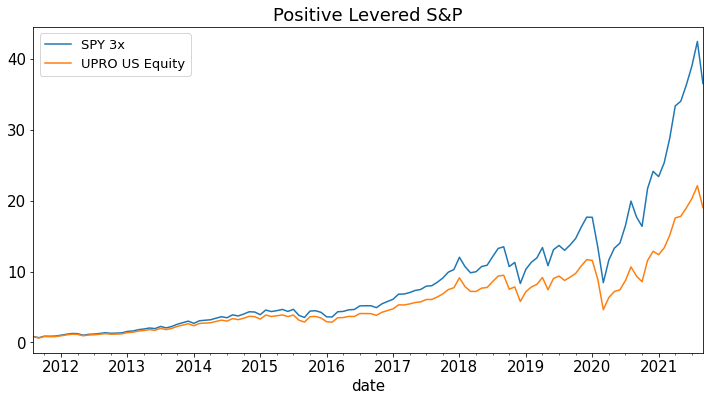

In [20]:
rets = spy.join(data[['SPXU US Equity','UPRO US Equity']],how='inner')
cumrets = (1+rets).cumprod()

cumrets_decay = pd.DataFrame((cumrets['UPRO US Equity'] / cumrets['SPY 3x']), columns=['+3x'])
cumrets_decay['-3x'] = (cumrets['SPXU US Equity'] / cumrets['SPY -3x'])

cumrets[['SPY 3x','UPRO US Equity']].plot(title='Positive Levered S&P');

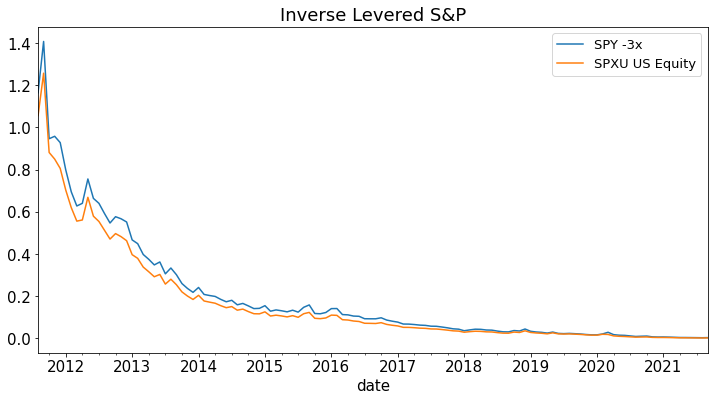

In [21]:
cumrets[['SPY -3x','SPXU US Equity']].plot(title='Inverse Levered S&P');

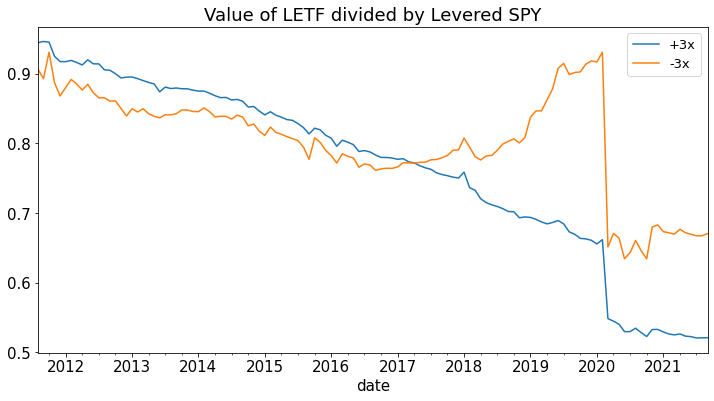

In [22]:
cumrets_decay.plot(title='Value of LETF divided by Levered SPY');

In [23]:
performanceMetrics(rets,annualization=12)

,Mean,Vol,Sharpe,Min,Max
SPY US Equity,0.147548,0.135363,1.090019,-0.124642,0.126984
SPY 3x,0.442644,0.406089,1.090019,-0.373927,0.380951
SPY -3x,-0.442644,0.406089,-1.090019,-0.380951,0.373927
SPXU US Equity,-0.498039,0.360813,-1.380325,-0.362355,0.276057
UPRO US Equity,0.388647,0.426964,0.910257,-0.481301,0.371695


In [24]:
maximumDrawdown(rets)

,Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
SPY US Equity,-0.194266,2019-12-31,2020-03-31,2020-07-31,213 days
SPY 3x,-0.523196,2019-12-31,2020-03-31,2020-08-31,244 days
SPY -3x,-0.997407,2011-09-30,2021-08-31,NaT,NaT
SPXU US Equity,-0.998063,2011-09-30,2021-08-31,NaT,NaT
UPRO US Equity,-0.604438,2019-12-31,2020-03-31,2020-12-31,366 days


In [30]:
get_ols_metrics(rets['SPY US Equity'],rets,annualization=12).drop(columns=['Treynor Ratio','Info Ratio']).style.format('{:.1%}')

,alpha,SPY US Equity,r-squared
SPY US Equity,0.0%,100.0%,100.0%
SPY 3x,-0.0%,300.0%,100.0%
SPY -3x,0.0%,-300.0%,100.0%
SPXU US Equity,-12.9%,-250.3%,88.2%
UPRO US Equity,-7.5%,314.2%,99.2%
